### Explore the data

In [9]:
import os
import time
import pyspark
from pyspark import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import VectorAssembler
import pandas as pd
start = time.time()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pyspark-Programming').getOrCreate()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
df = spark.read.csv('whosuicidestatistics.csv', header = True, inferSchema = True,nullValue='')
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)



##### data variable types

In [2]:
df.dtypes

[('country', 'string'),
 ('year', 'int'),
 ('sex', 'string'),
 ('age', 'string'),
 ('suicides_no', 'int'),
 ('population', 'int')]

#### Data variables and Observations

In [3]:
data=df

In [4]:
data.count(), len(data.columns)

(43776, 6)

    There are 43776 observations and 6 data attributes

### Projecting data

In [5]:
df.show(40)

+-------+----+------+-----------+-----------+----------+
|country|year|   sex|        age|suicides_no|population|
+-------+----+------+-----------+-----------+----------+
|Albania|1985|female|15-24 years|       null|    277900|
|Albania|1985|female|25-34 years|       null|    246800|
|Albania|1985|female|35-54 years|       null|    267500|
|Albania|1985|female| 5-14 years|       null|    298300|
|Albania|1985|female|55-74 years|       null|    138700|
|Albania|1985|female|  75+ years|       null|     34200|
|Albania|1985|  male|15-24 years|       null|    301400|
|Albania|1985|  male|25-34 years|       null|    264200|
|Albania|1985|  male|35-54 years|       null|    296700|
|Albania|1985|  male| 5-14 years|       null|    325800|
|Albania|1985|  male|55-74 years|       null|    132500|
|Albania|1985|  male|  75+ years|       null|     21100|
|Albania|1986|female|15-24 years|       null|    283900|
|Albania|1986|female|25-34 years|       null|    252100|
|Albania|1986|female|35-54 year

### Verify the data quality

This subsection only displays the quality of data and the ststistics might be wrong if the quality is not right

In [15]:
data.describe().show()

+-------+--------+------------------+------+-----------+-----------------+------------------+
|summary| country|              year|   sex|        age|      suicides_no|        population|
+-------+--------+------------------+------+-----------+-----------------+------------------+
|  count|   43776|             43776| 43776|      43776|            41520|             38316|
|   mean|    null|1998.5024671052631|  null|       null|193.3153901734104|1664091.1353742562|
| stddev|    null|10.338711176746282|  null|       null|800.5899259349637|3647231.2274873867|
|    min| Albania|              1979|female|15-24 years|                0|               259|
|    max|Zimbabwe|              2016|  male|  75+ years|            22338|          43805214|
+-------+--------+------------------+------+-----------+-----------------+------------------+



From the table above, it is noted that there are some missing observations in the dataset as well as wrong information which needs to handled before analysis. For instance the minimum age is given as 15-24 but it should be 5-14.

### Selecting data
Used for distribution analysis

#### Exploring distribution of numerical variables (suicide number and population)

In [7]:
from pyspark.sql.functions import col, skewness, kurtosis
data.select(skewness("suicides_no"),kurtosis("suicides_no")).show()

+---------------------+---------------------+
|skewness(suicides_no)|kurtosis(suicides_no)|
+---------------------+---------------------+
|   11.555061190754591|   195.78914619705236|
+---------------------+---------------------+



In [8]:
data.select(skewness("population"),kurtosis("population")).show()

+--------------------+--------------------+
|skewness(population)|kurtosis(population)|
+--------------------+--------------------+
|   4.651915786138693|  30.073363663428204|
+--------------------+--------------------+



### Cleanin The Dataset

##### Number of missing observations

###### Country Variable

In [9]:
df.where( df['country'].isNull() ).count()

0

###### Year

In [10]:
df.where( df['year'].isNull() ).count()

0

###### Sex

In [11]:
df.where( df['sex'].isNull() ).count()

0

###### Age

In [12]:
df.where( df['age'].isNull() ).count()

0

###### Suicide

In [13]:
df.where( df['suicides_no'].isNull() ).count()

2256

###### Population

In [14]:
df.where( df['population'].isNull() ).count()

5460

In [15]:
data.count()

43776

##### Dropping null observations

In [16]:
import pandas as pd
data = data.dropna(thresh=2, subset=['population', 'suicides_no'])

 ### Constructing the dataframe

In [17]:
data=pd.DataFrame(data.take(36060), columns=df.columns)

### Data Formatting

In [18]:
df=data
df_new=df[['country','suicides_no']]

#### Visual Exploration

##### Country and Suicide rates

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


df_new=df_new.groupby(['country'])['suicides_no'].agg('sum').sort_values(ascending=False).reset_index(name='suicides_no')

In [20]:
df_new.set_index('country', inplace=True)


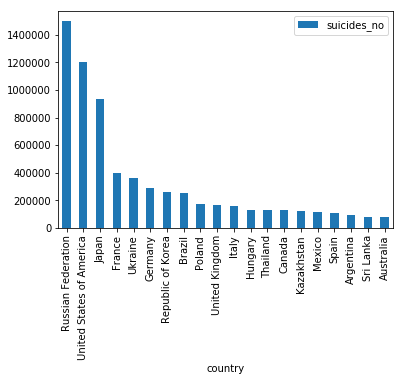

In [21]:
# graph 1 for suicides counrty wise
df_bar=df_new.head(20)
df_bar.plot(kind='bar')

### Year and Suicides

In [22]:
mean_stats=data.groupby("year")["suicides_no"].mean()
mean_stats['year'] =mean_stats.index

In [23]:
dft=pd.DataFrame(mean_stats)

In [24]:
dft['year'] =dft.index

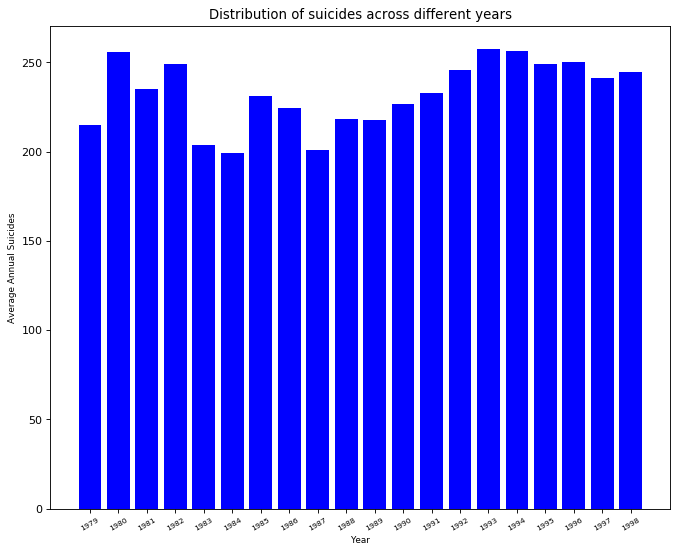

In [25]:
df=data
df_new=df[['year','suicides_no']]
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

label=list(dft['year'][0:20,])

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, dft['suicides_no'][0:20,], color='blue')
plt.xlabel('Year', fontsize=8)
plt.ylabel('Average Annual Suicides', fontsize=8)
plt.xticks(index, label, fontsize=7, rotation=30)
plt.title('Distribution of suicides across different years')
plt.show()

In [26]:
data.head()

,country,year,sex,age,suicides_no,population
0,Albania,1987,female,15-24 years,14,289700
1,Albania,1987,female,25-34 years,4,257200
2,Albania,1987,female,35-54 years,6,278800
3,Albania,1987,female,5-14 years,0,311000
4,Albania,1987,female,55-74 years,0,144600


##### Country and Population

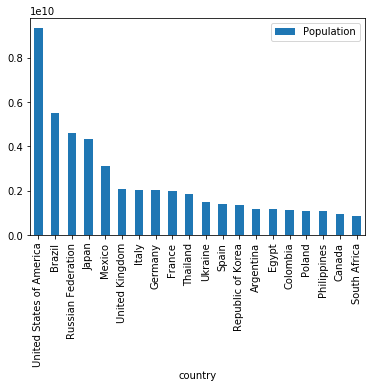

In [27]:
df_new=df[['country','population']]

df_new=df_new.groupby(['country'])['population'].agg('sum').sort_values(ascending=False).reset_index(name='Population')

df_new.set_index('country', inplace=True)
# graph 1 for suicides counrty wise
df_bar=df_new.head(20)
df_bar.plot(kind='bar')

#### Sex and Population 

In [28]:
df_pop=data[['sex','population']]

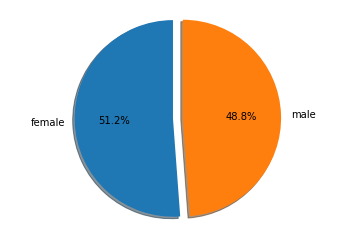

In [29]:
df_pop=data[['sex','population']]

df_pop=df_pop.groupby(['sex'])['population'].agg('sum').sort_values(ascending=False).reset_index(name='population')
gender = list(df_pop['sex'])
labels = list(gender)
sizes = list(df_pop['population'])
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, 
autopct='%1.1f%%',
    shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

#### Sex and Suicide 

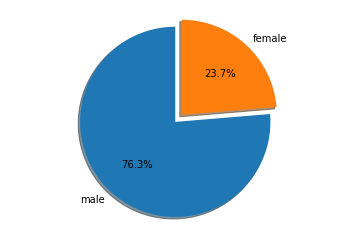

In [30]:
df_sex=df[['sex','suicides_no']]

df_sex=df_sex.groupby(['sex'])['suicides_no'].agg('sum').sort_values(ascending=False).reset_index(name='suicides_no')
gender = list(df_sex['sex'])
labels = list(gender)
sizes = list(df_sex['suicides_no'])
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, 
autopct='%1.1f%%',
    shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

#### Year and Population

In [31]:
mean_stats=data.groupby("year")["population"].mean()
mean_stats['year'] =mean_stats.index

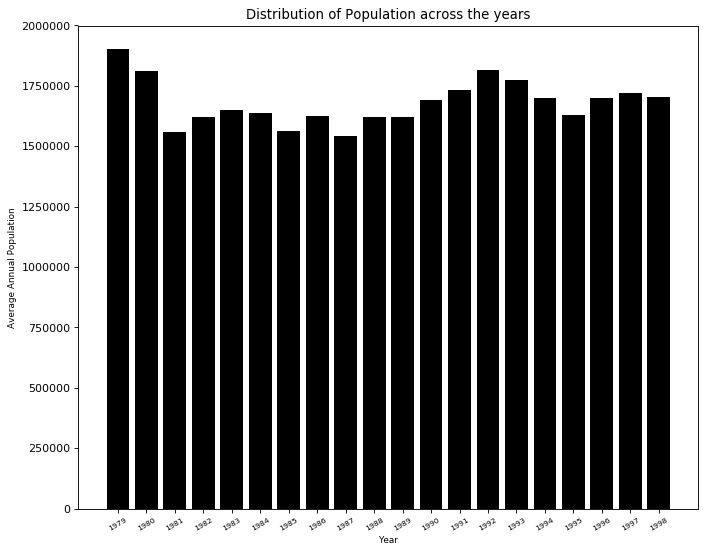

In [32]:
dft=pd.DataFrame(mean_stats)
dft['year'] =dft.index
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

label=list(dft['year'][0:20,])

# this is for plotting purpose
index = np.arange(len(label))
plt.bar(index, dft['population'][0:20,], color='black')
plt.xlabel('Year', fontsize=8)
plt.ylabel('Average Annual Population', fontsize=8)
plt.xticks(index, label, fontsize=7, rotation=30)
plt.title('Distribution of Population across the years')
plt.show()

In [33]:
data=spark.createDataFrame(data)


In [34]:
type(data)

pyspark.sql.dataframe.DataFrame

#### Categorical Variables to numerical 

In [35]:
cols = df.columns
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
'''The process includes Category Indexing, One-Hot Encoding and
VectorAssembler — a feature transformer that merges multiple columns into a vector column.'''

categoricalColumns = ['age', 'sex', 'country']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'suicides_no', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['year', 'suicides_no', 'population']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Creating new variables/attributes

#### Model definition

In [36]:
from pyspark.ml.feature import VectorAssembler
inputcols =['sex1','country1','population','age1']
assembler = VectorAssembler(inputCols= inputcols,
                            outputCol = "predictors")

In [37]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="sex", outputCol="sex1")
data = indexer.fit(data).transform(data)
indexer = StringIndexer(inputCol="country", outputCol="country1")
data = indexer.fit(data).transform(data)
indexer = StringIndexer(inputCol="age", outputCol="age1")
data = indexer.fit(data).transform(data)

#### Defining the predictors that will be used in the models

In [38]:

predictors = assembler.transform(data)
predictors.columns

['country',
 'year',
 'sex',
 'age',
 'suicides_no',
 'population',
 'sex1',
 'country1',
 'age1',
 'predictors']

In [39]:
model_data = predictors.select("predictors", "suicides_no")
model_data.show(5,truncate=False)

+-----------------------+-----------+
|predictors             |suicides_no|
+-----------------------+-----------+
|[0.0,79.0,289700.0,3.0]|14         |
|[0.0,79.0,257200.0,2.0]|4          |
|[0.0,79.0,278800.0,0.0]|6          |
|[0.0,79.0,311000.0,1.0]|0          |
|[0.0,79.0,144600.0,4.0]|0          |
+-----------------------+-----------+
only showing top 5 rows



##### Splitting data into test and train

In [40]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

#### Random Forest model preliminary data preparation

In [41]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf = RandomForestClassifier(labelCol="suicides_no", featuresCol="predictors", numTrees=10)

In [42]:
feature_list=['sex1','country1','population','age1']
assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [43]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="suicides_no", featuresCol="features")

In [44]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, rf])

In [45]:
labelIndexer = StringIndexer(inputCol="suicides_no", outputCol="suicides").fit(data)

In [46]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

transformed_df = data.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))

In [47]:
'''The process includes Category Indexing, One-Hot Encoding and
VectorAssembler — a feature transformer that merges multiple columns into a vector column.'''

categoricalColumns = ['sex','country','age']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'suicides_no', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['population','year']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [48]:
from pyspark.ml import Pipeline
'''We use Pipeline to chain multiple Transformers and Estimators together
to specify our machine learning workflow. 
A Pipeline’s stages are specified as an ordered array.'''
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(data)
data = pipelineModel.transform(data)
selectedCols = ['label', 'features']
df = data.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [49]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 25204
Test Dataset Count: 10856


#### Model Evaluation metrics

Model evaluation. In order to compare the performance of the models, the percentage of test error will be used for each of the classification and regerssion models while for the clustering model, the Within Set Sum of Squared Errors will be used

### Decision Tree Regressor

In [50]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

In [51]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

In [52]:
model = pipeline.fit(train)

In [53]:
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|(125,[0,8,119,123...|
|       1.0|         0.0|(125,[0,8,119,123...|
|       0.0|         0.0|(125,[0,15,119,12...|
|       0.0|         0.0|(125,[0,27,123,12...|
|       6.0|         0.0|(125,[0,27,123,12...|
+----------+------------+--------------------+
only showing top 5 rows



In [54]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

Test Error = 0.830785 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_81ff11b7e285) of depth 5 with 33 nodes


### Random Forest

In [55]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(125,[0,8,119,123...|
|           0.0|  0.0|(125,[0,8,119,123...|
|           0.0|  0.0|(125,[0,15,119,12...|
|           0.0|  0.0|(125,[0,27,123,12...|
|           0.0|  0.0|(125,[0,27,123,12...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0.835483
RandomForestClassificationModel (uid=RandomForestClassifier_a03233386935) with 10 trees


### Clustering

       In exploring the perfromance of the cluster algorithm, the WSSSW will be used i.e. Within set sum of squared errors (WSSSE). Which is basically a measure to explore the distance from each point to its centroid, the final centroid in each cluster, take the square of that error and sum it up for the entire Dataset. It's just a measure of how far apart each point is from its centroid

In [56]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(df)

# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(df)
print("Within Set Sum of Squared Errors = " + str(wssse))



Within Set Sum of Squared Errors = 2.5658251564998744e+16


The clustering model has a WSSSe of approximately 2.5683

In [57]:
# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[4.96159013e-01 1.40549106e-02 1.57084295e-02 0.00000000e+00
 1.52950498e-02 1.52950498e-02 3.78931413e-04 1.52950498e-02
 1.52950498e-02 3.34148610e-03 2.72141651e-03 1.52950498e-02
 1.27458748e-03 1.52950498e-02 2.03245031e-03 1.52950498e-02
 1.52950498e-02 1.52950498e-02 1.30903579e-03 1.52950498e-02
 2.85920976e-03 1.48816701e-02 1.48816701e-02 1.28147714e-02
 1.48816701e-02 1.48816701e-02 1.13679424e-03 1.40893589e-02
 1.44682903e-02 7.09635192e-03 1.44682903e-02 1.44682903e-02
 2.89365807e-03 1.40549106e-02 1.03344931e-03 1.40549106e-02
 1.40549106e-02 1.36415309e-02 1.36415309e-02 1.36415309e-02
 1.36415309e-02 1.33314961e-02 1.36415309e-02 1.36415309e-02
 1.36415309e-02 1.32281512e-02 8.43983603e-03 2.54917496e-03
 1.32281512e-02 1.32281512e-02 1.32281512e-02 3.78931413e-03
 1.32281512e-02 2.79031314e-03 1.28147714e-02 1.28147714e-02
 1.28147714e-02 2.51472665e-03 1.28147714e-02 1.28147714e-02
 1.24013917e-02 1.24013917e-02 7.61307658e-03 1.19880120e-02
 1.198